In [1]:
import cv2 as cv
import os
import IPython.display as ipd

import json

import numpy as np

import keras

from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# load keras model
model_number = 9
model = keras.models.load_model(f"./models/{model_number}_model.h5")

In [3]:
with open(f"models/{model_number}_model.json") as jf:
    mjson = json.load(jf)

# get mean and standard deviation learned by the train processor
# (featurewise center and std)
mu = np.array([float(e) for e in mjson["mean"]]).reshape(1,1,3)
std = np.array([float(e) for e in mjson["std"]]).reshape(1,1,3)

In [4]:
# Caricamento modello per il rilevamento di volti frontali
model_filename = 'C:/Users/gianc/Anaconda3/envs/dsim/Lib/site-packages/cv2/data/haarcascade_frontalface_default.xml'
face_detector = cv.CascadeClassifier(model_filename)

In [5]:
# I didn't save the "class_indicices" field for some models...
if "class_indices" not in mjson:
    if model.output_shape[1] == 8:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi", "umbe"])
        
    if model.output_shape[1] == 7:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "luca", "mamma", "papi"])
    if model.output_shape[1] == 6:
        labels = np.array(["alessandro", "alinda", "cami", "gian",
                           "mamma", "papi"])
    if model.output_shape[1] == 5:
        labels = np.array(["alinda", "cami",  "gian",
                           "mamma",  "papi",])
else:
    labels = np.array(mjson["class_indices"])

In [6]:
labels

array(['alessandro', 'alinda', 'cami', 'gian', 'luca', 'mamma', 'papi'],
      dtype='<U10')

# Test with webcam

In [7]:
def crop_picture(img, more_space=30):
    m = more_space # some additional space around the cropped face
    if img is not None:
        faces = face_detector.detectMultiScale(img[:,:,1]) # (img_gray)
        if len(faces) > 0:
            (x,y,w,h) = faces[0]
            img = img[(y-m):(y+h+m), (x-m):(x+w+m), :]
    return img[:,::-1]

In [8]:
def ranks(ar):
    return ar.argsort()[::-1]

In [9]:
def add_box(img, model, mu, std, labels, more_space=10):
    m = more_space
    if img is not None:
        faces = face_detector.detectMultiScale(img[:,:,1])
        face = 0
        fontColors = [(0,0,255), (255,160,0)]
        for (x,y,w,h) in faces:
            
            # -1::-1 because cv img is BGR, but we need RGB (check)
            img2 = img[:,:,::-1]
            # the model was fed with cropped images
            img2 = crop_picture(img2)
            # resize to match model input shape
            img2 = cv.resize(img2, (224, 224))
            
            img2 = (img2 - mu)/std
            
            # prediction
            pred = model.predict(img2[np.newaxis,:,:,:])[0]
                        
            text = labels[np.argmax(pred)]

            top3 = labels[ranks(pred)][:2]
            conf3 = pred[ranks(pred)][:2]
            
            font                   = cv.FONT_HERSHEY_PLAIN
            bottomLeftCornerOfText = (x-m,y-m-5)
            fontScale              = 2
            fontColor              = fontColors[face]
            lineType               = 2
            
            
            cv.rectangle(img,(x-m,y-m),(x+w+m,y+h+m),fontColor,2)
            cv.putText(img, text, bottomLeftCornerOfText, 
                       font, fontScale, fontColor, lineType)
            
            for i in range(len(top3)):
                line = "{}: {}".format(top3[i], str(np.around(conf3[i]*100, decimals = 2))+"%")
                cv.putText(img, line, (10, 25+30*i+face*420), # this won't work for more than two faces
                           font, fontScale, fontColor, lineType)
            face += 1
            
            if face > 1:
                # this function would not work for more than two faces anyway
                break
        
    return img

In [10]:
def test_model(model, mu, std, labels):
    labels = np.array(labels)
    cap = cv.VideoCapture(0)
    while(True):
        
        r, frame = cap.read()
        
        try:
            frame = add_box(frame, model, mu, std, labels)
            cv.imshow('Video', frame)
            
        except Exception as e:
            # print(e)
            pass

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
                        
    cap.release()
    cv.destroyAllWindows()

In [11]:
test_model(model, mu, std, labels)

# Test single shot

In [12]:
def test_model_single_shot(model, mu, std, labels):
    cap = cv.VideoCapture(0)
    result, img = cap.read()
    cap.release()
    plt.figure(figsize=(14,7))
    plt.imshow(add_box(img, model, mu, std, labels)[:,:,::-1])

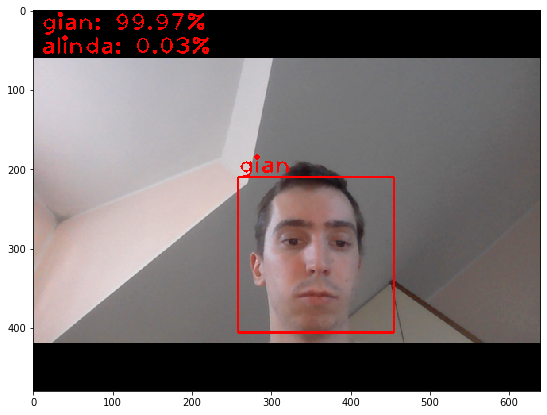

In [13]:
test_model_single_shot(model, mu, std, labels)

# Test on directories

In [ ]:
labels

In [ ]:
# might make sense to test on some pictures not used during training
name = "mamma"
basedir = "pictures_table/"+name
counts={}
for label in labels:
    counts[label] = 0
total = 1
for file in os.listdir(basedir):
    img = cv.imread(basedir+"/"+file)
    img2 = img[:,:,::-1]
    img2 = cv.resize(img2, (224, 224))
    img2 = (img2 - mu)/std

    pred = model.predict(img2[np.newaxis,:,:,:])
    
    text = labels[np.argmax(pred)]
    counts[text] += 1
    ipd.clear_output(wait=True)
    for i in counts.keys():
        print("{}: {}".format(i, counts[i]))
    print("\ntotal: ", total)
    print("accuracy: ", counts[name]/total)
    total += 1